## Работа 2.1.6

# Эффект Джоуля–Томсона

### Цель работы:

1. Определение изменения температуры углекислого газа при протекании через малопроницаемую перегородку при разных начальных значениях давления и температуры.

2. Вычисление по результатам опытов коэффициентов Ван-дер-Ваальса $a$ и $b$.

### В работе используются: 

* трубка с пористой перегородкой
* труба Дьюара
* термостат
* термометры
* дифференциальная термопара
* микровольтметр
* балластный баллон
* манометр

## 1. Теория

Эффектом Джоуля - Томсона называется изменение температуры газа при адиабатическом дросселировании — медленном протекании газа под действием постоянного перепада давлений сквозь дроссель (пористую перегородку). Данный эффект является одним из методов получения низких температур.

В работе исследуется изменение температуры углекислого газа при медленном его течении по трубке с пористой перегородкой. Величина коэффициента Джоуля - Томсона определяется по разности температур до и после перегородки.



## 2. Рабочая установка

![Рабочая_Установка](images/laboratory_scale_plant.png)

## 3. Процесс работы

1. Установить на термостате температуру, близкую к комнатной и запустить термостат.

2. Установить $P \approx 4 atm$ и медленно понижать его, измеряя температуру газа при значениях, для которых давление и температура установятся.

3. Построить график $dP(dT)$ и по наклону этого графика определить коэфф. Джоуля - Томпсона.

Переводить напряжение вольтметра в температуру следует с учётом следующей таблицы:

![Таблица](images/convertion.png)

4. Повторить предыдущие два пункта для двух других значений температуры.

5. С помощью полученных значений коэфф. Джоуля - Томпсона для трёх температур определить $a$ и $b$ - коэффициенты газа Ван-дер-Ваальса.

6. С помощью полученных значений определить температуру инверсии этилового спирта.

In [21]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
from scipy import optimize as sp_opt
from scipy import odr as sp_odr
from IPython.display import display
%matplotlib inline

In [22]:
data = [pd.read_csv('data/data_{}.csv'.format(str(i))) for i in range(3)]

R = 8.3144598
Cp = 3 * R

In [23]:
for dataset in data:
    display(dataset)

dP   dT
0  4.0  3.7
1  3.6  3.3
2  3.2  2.9
3  2.8  2.5
4  2.4  2.1
5  2.0  1.7

dP   dT
0  4.0  3.4
1  3.6  3.1
2  3.2  2.7
3  2.8  2.3
4  2.4  1.9
5  2.0  1.5

dP   dT
0  4.0  2.8
1  3.6  2.5
2  3.2  2.2
3  2.8  1.8
4  2.4  1.5
5  2.0  1.2

mu: [ 0.90516277]
mean_squared_error: [ 0.00968262]
relative_error: [ 0.01069711]
None
mu: [ 0.83497804]
mean_squared_error: [ 0.01383904]
relative_error: [ 0.01657413]
None
mu: [ 0.6744452]
mean_squared_error: [ 0.01471145]
relative_error: [ 0.02181267]
None


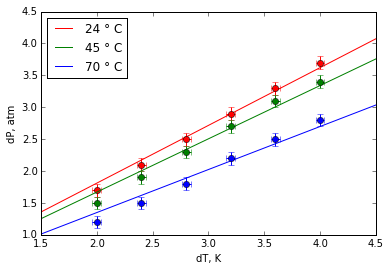

In [24]:
colors = ['r', 'g', 'b']
temperatures = [24, 45, 70]
coefs = [0, 0, 0]

def f(B, x):
    return B[0] * x

for idx, dataset in enumerate(data):
    odr_model = sp_odr.Model(f)
    odr_data = sp_odr.RealData(x = dataset['dP'], y = dataset['dT'], sx = 0.01, sy = 0.01)
    odr = sp_odr.ODR(odr_data, odr_model, beta0 = [0], maxit = 1000000)
    odr_output = odr.run()
    print(print('mu: {}\nmean_squared_error: {}\nrelative_error: {}'
                .format(odr_output.beta, odr_output.sd_beta, odr_output.sd_beta / odr_output.beta)))
    coefs[idx] = odr_output.beta[0]
    
    x = np.linspace(min(dataset['dP']) - 0.5, max(dataset['dP']) + 0.5)
    y = f([coefs[idx]], x)
    plt.plot(x, y, label='{} ° C'.format(str(temperatures[idx])), color=colors[idx])
    plt.errorbar(dataset['dP'], dataset['dT'], color=colors[idx], fmt='o', xerr=0.04, yerr=0.1, label='')

plt.xlabel('dT, K')
plt.ylabel('dP, atm')
plt.legend(loc=2)
plt.show()

## Вычисленные значения коэффициента Джоуля-Томпсона

$$ \mu_1 = 0.90516277 \pm 0.00968262 atm/K $$
$$ \mu_2 = 0.83497804 \pm 0.01383904 atm/K $$
$$ \mu_3 = 0.6744452 \pm 0.01471145 atm/K $$

In [25]:
def f(B, x):
    return ((2 * B[0]) / (R * x) - B[1]) / (Cp)

def plot_coefs():
    X = [1 / (T + 273.15) for T in temperatures]
    Y = coefs

    odr_model = sp_odr.Model(f)
    odr_data = sp_odr.RealData(x = X, y = Y,
                               sx = 0.01 / 300, sy = [0.00968262, 0.01383904, 0.01471145])
    odr = sp_odr.ODR(odr_data, odr_model, beta0 = [0, 0], maxit = 1000000)
    odr_output = odr.run()
    print(print('k: {}\nmean_squared_error: {}\nrelative_error: {}'
                .format(odr_output.beta, odr_output.sd_beta, abs(odr_output.sd_beta / odr_output.beta))))
    
    k = odr_output.beta

    x = np.linspace(0.9 * min(X), 1.1 * max(X))
    y = f(k, x)
    plt.plot(x, y)
    plt.errorbar(X, Y, xerr=0.01 / 300, yerr=[0.00968262, 0.01383904, 0.01471145], fmt='o', label='')
    plt.xlabel('1 / T, 1 / K')
    plt.ylabel('mu_jt, K / atm')
    
    return k
    
a, b = plot_coefs()

k: [ -0.69036074 -79.79412275]
mean_squared_error: [ 0.12286137  9.31282987]
relative_error: [ 0.17796691  0.11671072]
None


## Вычисление коэффициентов $a$ и $b$

Используем следующее соотношение для вычисления параметров уравнения Ван-дер-Ваальса $a$ и $b$:

$${\mu_{д-т}} = {{\Delta T}\over{\Delta P}} \approx {{{{2a}\over{RT}} - b}\over{C_p}}$$


Зная $\mu_1$ и $\mu_2$ при двух температурах - $T_1$ и $T_2$, можно составить два уравнения и решить их относительно $a$ и $b$:

$$ {b} = {C_p {{\mu_2 - \mu_1}\over{T_1 - T_2}}} $$
$$ {a} = {{R T_1 (\mu_1 C_p + b)}\over{2}} = {R T_1 C_p (\mu_1 + {{\mu_2 - \mu_1}\over{T_1 - T_2}})} $$

$$ {T_{инв}} = {{2a}\over{Rb}} $$

### 1. Для $t = 24.57 ° C$ и $t = 45 ° C$:

$ a = 0.676 Н * м^2 / {моль}^2, b = 22.828 {см}^3/моль, T_{инв} = 722 K $

### 2. Для $t = 45 ° C$ и $t = 65 ° C$:

$ a = 0.485 Н * м^2 / {моль}^2, b = 80.49 {см}^3/моль, T_{инв} = 1430 K $